# Reconstruction

Reference: https://tomroelandts.com/articles/astra-toolbox-tutorial-reconstruction-from-projection-images-part-2

In [19]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
from cryoem.reconstruction import reconstruct
from cryoem.conversions import quaternion2euler

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
projections = data['Projections']
angles_true = np.array(data['Angles'])

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


---

# True Angles and Projections

## Create data for reconstruction (projections and angles pairs)

## Reconstruction

In [4]:
reconstruction = reconstruct(projections[:3000], angles_true[:3000], mrc_filename=None)

## Plot reconstruction result

In [7]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
#mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

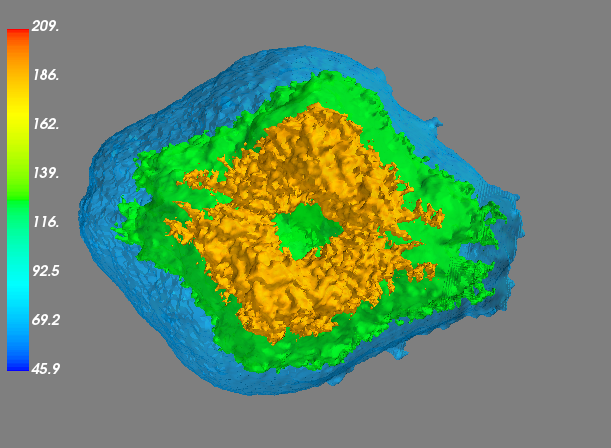

In [8]:
Image(filename='data/5a1a_projections_and_angles.png') 

---

# Predicted Angles and Projections (Perfect)

## Reconstruction

In [10]:
angles_predicted = np.load("../1-phase1/data/predicted_angles.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [11]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

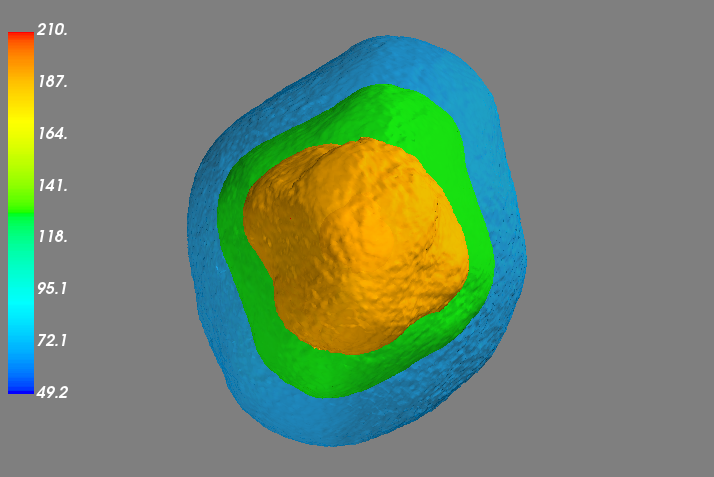

In [13]:
Image(filename='data/5a1a_projections_and_angles_predicted.png')

## After Angle Alignment

In [14]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_updated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [15]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

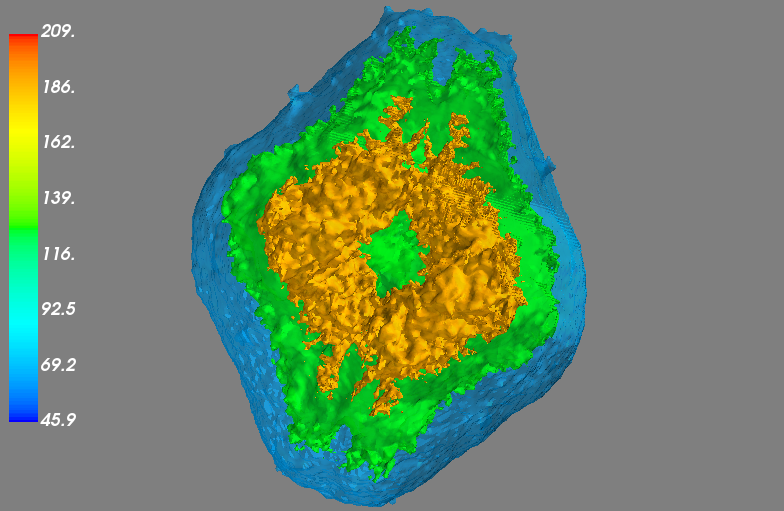

In [16]:
Image(filename='data/5a1a_projections_and_angles_predicted_updated.png')

---

# Predicted Angles and Projections (Variance 0.0)

## Reconstruction

In [4]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_var00.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [7]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

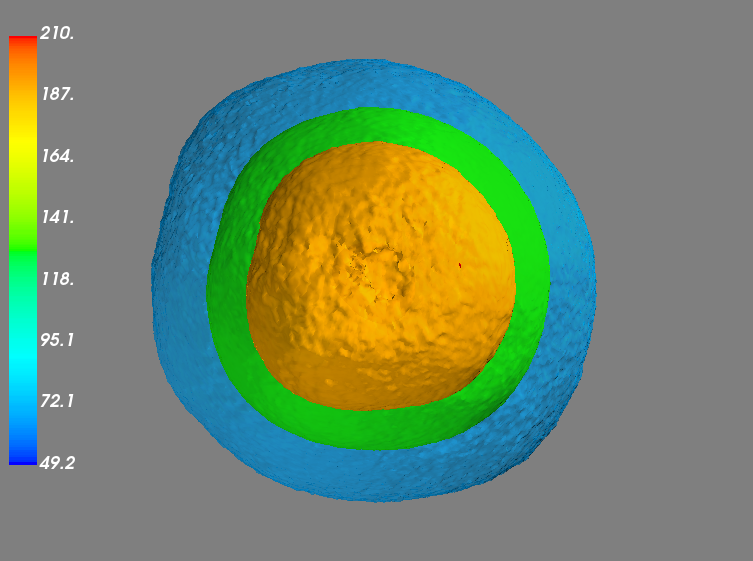

In [8]:
Image(filename='data/5a1a_projections_and_angles_predicted_var00.png')

## After Angle Alignment

In [8]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_var00_updated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [11]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

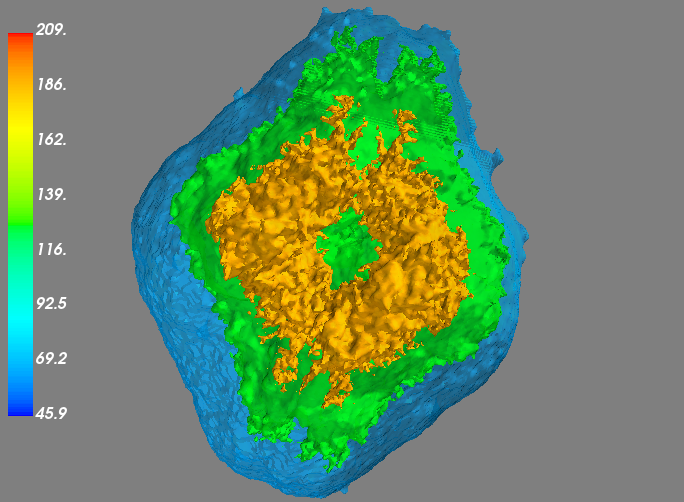

In [12]:
Image(filename='data/5a1a_projections_and_angles_predicted_var00_updated.png')

---

# Predicted Angles and Projections (Variance 0.1)

## Reconstruction

In [5]:
angles_predicted = np.load("data/angles_predicted_var01.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [6]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

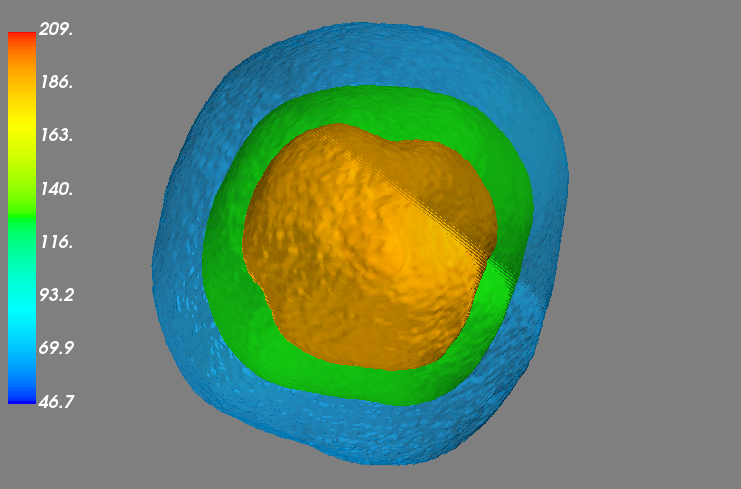

In [7]:
Image(filename='data/5a1a_projections_and_angles_predicted_var01.png')

## After Angle Alignment

In [4]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_var01_updated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [5]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

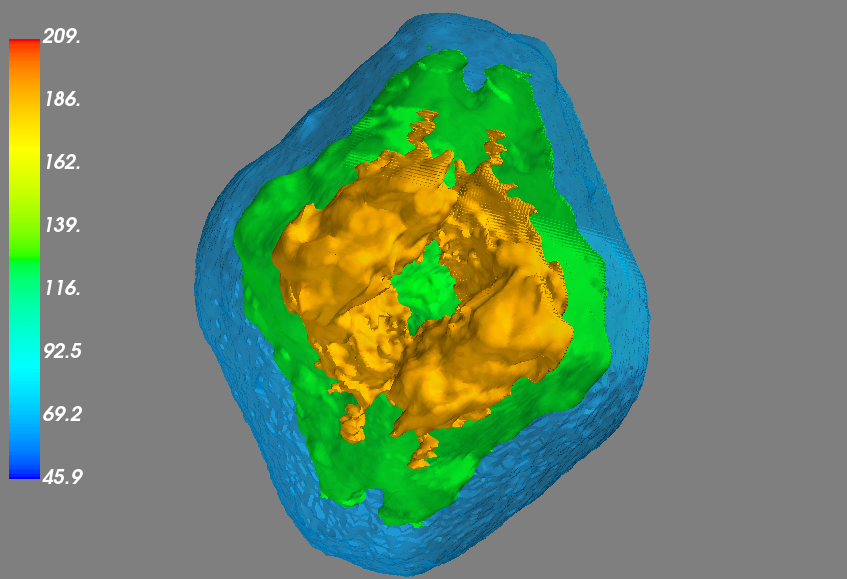

In [6]:
Image(filename='data/5a1a_projections_and_angles_predicted_var01_updated.png')

---

# Predicted Angles and Projections (Variance 0.2)

## Reconstruction

In [7]:
angles_predicted = np.load("data/angles_predicted_var02.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [8]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

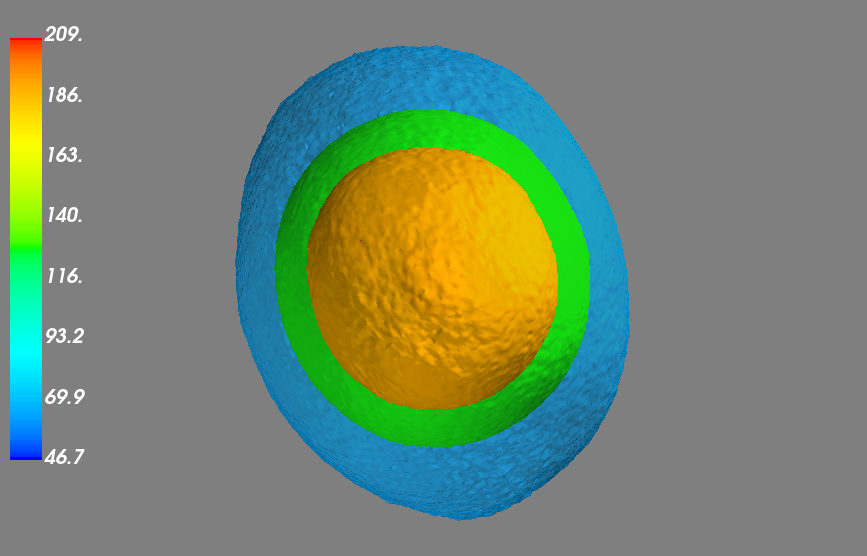

In [9]:
Image(filename='data/5a1a_projections_and_angles_predicted_var02.png')

## After Angle Alignment

In [10]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_var02_updated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [11]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

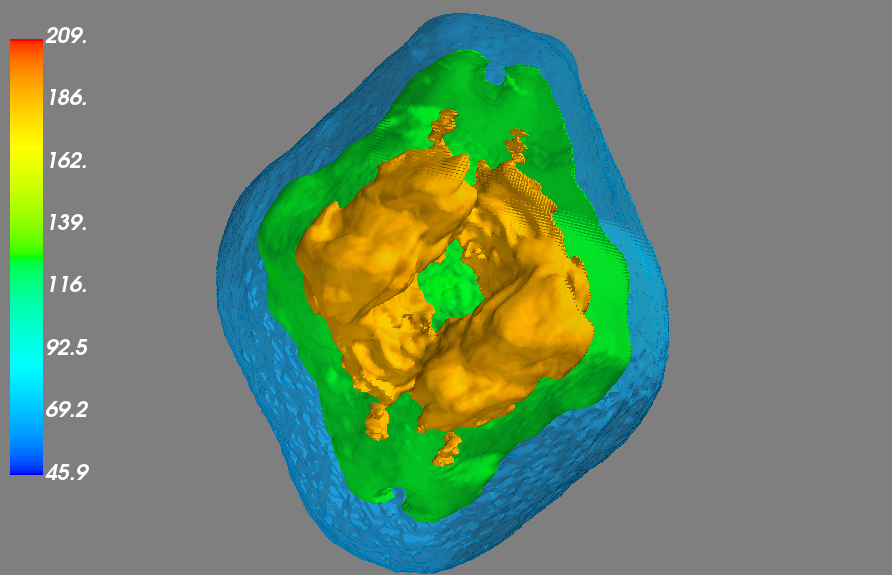

In [12]:
Image(filename='data/5a1a_projections_and_angles_predicted_var02_updated.png')

---

# Predicted Angles and Projections (Variance 0.3)

## Reconstruction

In [13]:
angles_predicted = np.load("data/angles_predicted_var03.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [14]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

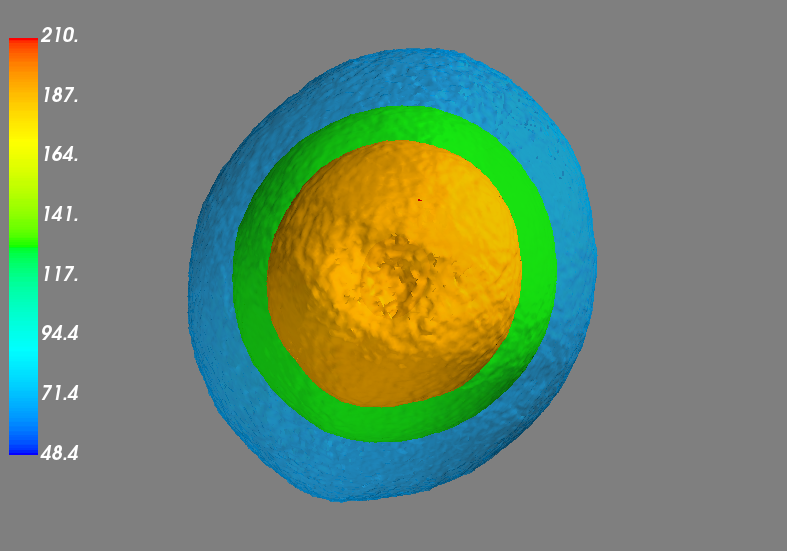

In [15]:
Image(filename='data/5a1a_projections_and_angles_predicted_var03.png')

## After Angle Alignment

In [16]:
angles_predicted = np.load("../1-phase1/data/predicted_angles_var03_updated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename=None)

In [17]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

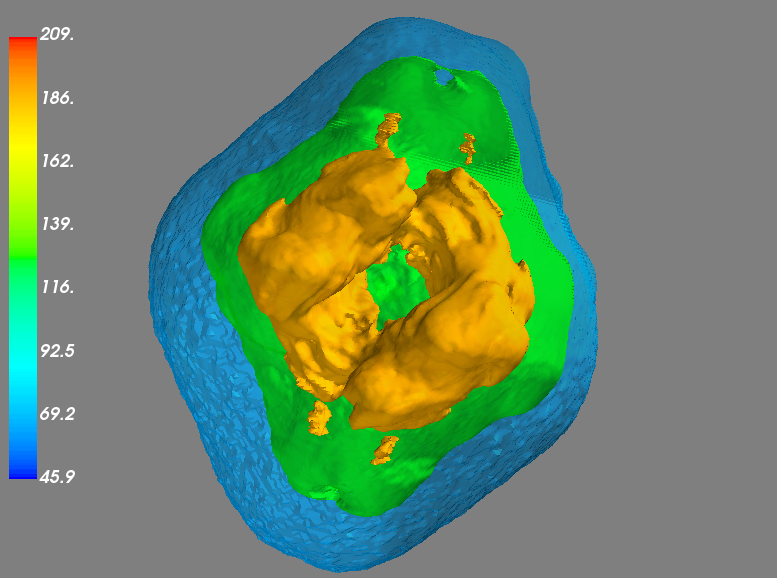

In [18]:
Image(filename='data/5a1a_projections_and_angles_predicted_var03_updated.png')

---